In [5]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy pandas_datareader

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
import yfinance as yf
import pandas_datareader as pdr
from time import time

In [6]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = ['^GSPC','JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'BLK', 'SCHW', 'AXP', 'COF', 'DFS',
'V', 'MA', 'PYPL', 'ICE', 'CME', 'CBOE', 'NDAQ', 'SPGI', 'MCO', 'MSCI',
'BK', 'STT', 'NTRS', 'BEN', 'IVZ', 'TROW', 'AMP', 'RJF', 'LNC', 'PRU',
'MET', 'AFL', 'AIG', 'ALL', 'TRV', 'CB', 'PGR', 'CINF', 'L', 'AJG',
'MMC', 'AON', 'BRO', 'WTW', 'BRK.B', 'USB', 'PNC', 'TFC', 'MTB', 'FITB',
'KEY', 'RF', 'CFG', 'HBAN', 'CMA', 'ZION', 'FHN', 'ACGL', 'GL',
'AIZ', 'UNM', 'BHF', 'GNW', 'AMG', 'JEF', 'SYF', 'ALLY', 'COIN',
'HOOD', 'IBKR', 'MKTX', 'FDS', 'WRB', 'ERIE', 'HIG', 'BX', 'KKR', 'APO']

data = data[[t for t in selected_assets if t in data.columns]]
data_clean = data.dropna(axis=1, how='any')

start_date = data_clean.index[0]
end_date = data_clean.index[-1]

# VIX
vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False)
vix = vix_raw['Close']['^VIX'] if isinstance(vix_raw.columns, pd.MultiIndex) else vix_raw['Close']

# Real Rate (from FRED)
real_rate = pdr.DataReader('DFII10', 'fred', start_date, end_date)['DFII10']

# Align
state_vars = pd.DataFrame({
    'VIX': vix,
    'RealRate': real_rate
}).reindex(data_clean.index).ffill().dropna()

common_dates = data_clean.index.intersection(state_vars.index)
asset_data = data_clean.loc[common_dates]
state_vars = state_vars.loc[common_dates]

pnl = np.log(asset_data / asset_data.shift(1)).dropna()
state_vars = state_vars.loc[pnl.index]

print(f"Assets: {pnl.shape[1]} | Days: {len(pnl)} | Range: {pnl.index[0].date()} to {pnl.index[-1].date()}")
print(f"{len(pnl) / 252:.1f} years of daily data.")

/tmp/ipykernel_266/4017036585.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False)


Assets: 74 | Days: 2470 | Range: 2016-01-05 to 2025-11-11
9.8 years of daily data.


In [7]:
window_size = 504   # ~2 years lookback
step_size = 126     # ~6 months step
S = 10000           # simulations per window
H = 21              # horizon (1 month)
alpha = 0.90        # CVaR confidence level

n_windows = (len(pnl) - window_size) // step_size + 1

print(f"Window size: {window_size} days (~{window_size/252:.1f} years)")
print(f"Step size: {step_size} days (~{step_size/252:.1f} years)")
print(f"Total windows: {n_windows}")
print(f"Simulations per window: {S:,}")
print(f"Horizon: {H} days")

Window size: 504 days (~2.0 years)
Step size: 126 days (~0.5 years)
Total windows: 16
Simulations per window: 10,000
Horizon: 21 days


In [8]:
print("Window schedule:\n")
for w in range(n_windows):
    start_idx = w * step_size
    end_idx = start_idx + window_size
    start_date = pnl.index[start_idx].date()
    end_date = pnl.index[end_idx - 1].date()
    print(f"  Window {w+1:2d}: {start_date} → {end_date}")

Window schedule:

  Window  1: 2016-01-05 → 2018-01-05
  Window  2: 2016-07-06 → 2018-07-09
  Window  3: 2017-01-05 → 2019-01-09
  Window  4: 2017-07-07 → 2019-07-11
  Window  5: 2018-01-08 → 2020-01-10
  Window  6: 2018-07-10 → 2020-07-13
  Window  7: 2019-01-10 → 2021-01-12
  Window  8: 2019-07-12 → 2021-07-14
  Window  9: 2020-01-13 → 2022-01-12
  Window 10: 2020-07-14 → 2022-07-15
  Window 11: 2021-01-13 → 2023-01-17
  Window 12: 2021-07-15 → 2023-07-19
  Window 13: 2022-01-13 → 2024-01-19
  Window 14: 2022-07-18 → 2024-07-22
  Window 15: 2023-01-18 → 2025-01-23
  Window 16: 2023-07-20 → 2025-07-25


In [9]:
def classify_states(vix, realrate):
    """Classify into 9 states (3 VIX × 3 RealRate levels)."""
    vix_25, vix_90 = np.percentile(vix, [25, 90])
    rr_25, rr_75 = np.percentile(realrate, [25, 75])
    
    vix_state = np.where(vix <= vix_25, 0, np.where(vix <= vix_90, 1, 2))
    rr_state = np.where(realrate <= rr_25, 0, np.where(realrate <= rr_75, 1, 2))
    
    return vix_state + 3 * rr_state


def entropy_pooling_by_state(log_returns, vix, realrate, states_vector, n_states=9):
    """Compute EP posterior for each state."""
    T = len(log_returns)
    p_exp = ft.exp_decay_probs(log_returns, half_life=T / 2)
    
    # State moments
    mu_vix = np.array([vix[states_vector == s].mean() if (states_vector == s).sum() > 0 else vix.mean() for s in range(n_states)])
    sigma_vix = np.array([vix[states_vector == s].std() if (states_vector == s).sum() > 0 else vix.std() for s in range(n_states)])
    mu_rr = np.array([realrate[states_vector == s].mean() if (states_vector == s).sum() > 0 else realrate.mean() for s in range(n_states)])
    sigma_rr = np.array([realrate[states_vector == s].std() if (states_vector == s).sum() > 0 else realrate.std() for s in range(n_states)])
    
    # Constraint matrices
    A = np.vstack((np.ones((1, T)), vix[np.newaxis, :], realrate[np.newaxis, :]))
    G = np.vstack((vix[np.newaxis, :] ** 2, realrate[np.newaxis, :] ** 2))
    
    q_states = []
    for s in range(n_states):
        b = np.array([[1.], [mu_vix[s]], [mu_rr[s]]])
        h = np.array([[sigma_vix[s]**2 + mu_vix[s]**2], [sigma_rr[s]**2 + mu_rr[s]**2]])
        
        try:
            q = ft.entropy_pooling(p_exp, A, b, G, h)
            q_states.append(q / q.sum())
        except:
            q_states.append(p_exp / p_exp.sum())
    
    return np.hstack(q_states)


def resample_paths(S, H, initial_state, states_prob, states_vector):
    """Markov-like resampling across states."""
    T = len(states_vector)
    t_indices = np.arange(T)
    sim = np.zeros((S, H), dtype=int)
    
    for s in range(S):
        state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t_indices, p=states_prob[:, state])
            state = states_vector[sim[s, h]]
    
    return sim


def weighted_cvar(returns, probs, alpha):
    """Compute CVaR for each asset under probability weights."""
    n_assets = returns.shape[1]
    cvar = np.zeros(n_assets)
    
    for i in range(n_assets):
        sorted_idx = np.argsort(returns[:, i])
        sorted_ret = returns[sorted_idx, i]
        sorted_p = probs[sorted_idx]
        cum_p = np.cumsum(sorted_p)
        tail_mask = cum_p <= (1 - alpha)
        cvar[i] = np.average(sorted_ret[tail_mask], weights=sorted_p[tail_mask]) if tail_mask.sum() > 0 else sorted_ret[0]
    
    return cvar

In [11]:
def run_window(pnl_w, state_vars_w, S=10000, H=21, alpha=0.90):
    """
    Full pipeline for one window:
    1. Classify states
    2. EP posteriors per state
    3. Simulate paths
    4. Compute mean-CVaR efficiency
    
    Returns: DataFrame with efficiency metrics per asset
    """
    log_returns = pnl_w.values
    vix = state_vars_w['VIX'].values
    realrate = state_vars_w['RealRate'].values
    
    states_vector = classify_states(vix, realrate)
    initial_state = states_vector[-1]
    
    states_prob = entropy_pooling_by_state(log_returns, vix, realrate, states_vector)
    
    sim_idx = resample_paths(S, H, initial_state, states_prob, states_vector)
    returns_sim = np.exp(np.cumsum(log_returns[sim_idx], axis=1))[:, -1, :] - 1
    
    p_uniform = np.ones(S) / S
    sim_mean = p_uniform @ returns_sim * 100
    sim_cvar = weighted_cvar(returns_sim, p_uniform, alpha) * 100
    efficiency = sim_mean / (-sim_cvar)
    
    return pd.DataFrame({
        'Mean': sim_mean,
        'CVaR': sim_cvar,
        'Efficiency': efficiency
    }, index=pnl_w.columns)

In [12]:
results = []
np.random.seed(42)

print(f"Running {n_windows} windows × {S:,} simulations...\n")
t_start = time()

for w in range(n_windows):
    start_idx = w * step_size
    end_idx = start_idx + window_size
    
    pnl_w = pnl.iloc[start_idx:end_idx]
    state_vars_w = state_vars.iloc[start_idx:end_idx]
    
    window_start = pnl_w.index[0].date()
    window_end = pnl_w.index[-1].date()
    
    t_w = time()
    eff_df = run_window(pnl_w, state_vars_w, S=S, H=H, alpha=alpha)
    eff_df['Window'] = w + 1
    eff_df['Window_End'] = window_end
    eff_df['Ticker'] = eff_df.index
    results.append(eff_df)
    
    elapsed = time() - t_w
    total_elapsed = time() - t_start
    print(f"  Window {w+1:2d}/{n_windows}: {window_start} → {window_end} | {elapsed:.1f}s")

print(f"\nDone. Total time: {total_elapsed/60:.1f} min")

Running 16 windows × 10,000 simulations...

  Window  1/16: 2016-01-05 → 2018-01-05 | 6.0s
  Window  2/16: 2016-07-06 → 2018-07-09 | 5.8s
  Window  3/16: 2017-01-05 → 2019-01-09 | 6.0s
  Window  4/16: 2017-07-07 → 2019-07-11 | 5.9s
  Window  5/16: 2018-01-08 → 2020-01-10 | 6.5s
  Window  6/16: 2018-07-10 → 2020-07-13 | 5.3s
  Window  7/16: 2019-01-10 → 2021-01-12 | 6.0s
  Window  8/16: 2019-07-12 → 2021-07-14 | 6.5s
  Window  9/16: 2020-01-13 → 2022-01-12 | 5.8s
  Window 10/16: 2020-07-14 → 2022-07-15 | 6.4s
  Window 11/16: 2021-01-13 → 2023-01-17 | 6.7s
  Window 12/16: 2021-07-15 → 2023-07-19 | 6.3s
  Window 13/16: 2022-01-13 → 2024-01-19 | 6.2s
  Window 14/16: 2022-07-18 → 2024-07-22 | 5.8s
  Window 15/16: 2023-01-18 → 2025-01-23 | 6.3s
  Window 16/16: 2023-07-20 → 2025-07-25 | 7.0s

Done. Total time: 1.6 min


In [16]:
all_results = pd.concat(results, ignore_index=True)
all_results = all_results[['Ticker', 'Window', 'Window_End', 'Mean', 'CVaR', 'Efficiency']]

print(f"Shape: {all_results.shape}")
print(f"Windows: {all_results['Window'].nunique()}")
print(f"Assets: {all_results['Ticker'].nunique()}")
# all_results.head(10)

Shape: (1184, 6)
Windows: 16
Assets: 74


In [17]:
summary = all_results.groupby('Ticker')['Efficiency'].agg([
    ('Mean_Eff', 'mean'),
    ('Median_Eff', 'median'),
    ('Std_Eff', 'std'),
    ('Min_Eff', 'min'),
    ('Max_Eff', 'max')
]).round(4)

summary = summary.sort_values('Mean_Eff', ascending=False)

print("Top 15 by Average Efficiency Across All Windows:\n")
print(summary.head(15))

Top 15 by Average Efficiency Across All Windows:

        Mean_Eff  Median_Eff  Std_Eff  Min_Eff  Max_Eff
Ticker                                                 
^GSPC     0.6703      0.4466   0.6310  -0.0659   1.9694
APO       0.6399      0.5322   0.6073  -0.0281   1.8951
KKR       0.6155      0.6719   0.3967  -0.0106   1.3304
JPM       0.6005      0.5428   0.4623   0.0692   1.9332
AMP       0.5430      0.4244   0.4845   0.0061   1.6484
BRO       0.5339      0.3958   0.4648  -0.0251   1.6301
BX        0.5266      0.3582   0.4345  -0.0779   1.2663
MSCI      0.5094      0.3978   0.5184  -0.0064   1.6529
JEF       0.5063      0.3986   0.3872  -0.0479   1.2828
AXP       0.5062      0.4196   0.4074  -0.0378   1.3377
MS        0.4999      0.3742   0.3718   0.0598   1.1019
GS        0.4984      0.4690   0.3659  -0.0648   1.1371
MA        0.4903      0.3318   0.5294  -0.0113   1.6986
BRK.B     0.4893      0.3408   0.3855   0.0108   1.1657
IBKR      0.4881      0.3574   0.4839   0.0344   2.034

In [18]:
def count_top_n(df, n=10):
    """Count how many windows each ticker ranked in top N."""
    counts = {}
    for w in df['Window'].unique():
        top_n = df[df['Window'] == w].nlargest(n, 'Efficiency')['Ticker'].values
        for t in top_n:
            counts[t] = counts.get(t, 0) + 1
    return pd.Series(counts).sort_values(ascending=False)

top10_counts = count_top_n(all_results, n=10)
top20_counts = count_top_n(all_results, n=20)

consistency = pd.DataFrame({
    'Top10_Count': top10_counts,
    'Top20_Count': top20_counts,
    'Top10_Pct': (top10_counts / n_windows * 100).round(1),
    'Top20_Pct': (top20_counts / n_windows * 100).round(1)
}).fillna(0).astype({'Top10_Count': int, 'Top20_Count': int})

consistency = consistency.sort_values('Top10_Count', ascending=False)

print(f"Rank Consistency Across {n_windows} Windows:\n")
print(consistency.head(20))

Rank Consistency Across 16 Windows:

       Top10_Count  Top20_Count  Top10_Pct  Top20_Pct
APO              7            9       43.8       56.2
ERIE             5            6       31.2       37.5
KKR              5           10       31.2       62.5
^GSPC            5            9       31.2       56.2
MSCI             5            6       31.2       37.5
BRK.B            5            6       31.2       37.5
IBKR             5            7       31.2       43.8
GS               4            7       25.0       43.8
AIZ              4            6       25.0       37.5
JPM              4           10       25.0       62.5
JEF              4            8       25.0       50.0
AXP              4            6       25.0       37.5
V                4            5       25.0       31.2
MA               4            4       25.0       25.0
BX               4            8       25.0       50.0
AFL              3            8       18.8       50.0
ACGL             3            7       18.8   

In [19]:
final_ranking = summary.join(consistency, how='left').fillna(0)
final_ranking = final_ranking.astype({'Top10_Count': int, 'Top20_Count': int})
final_ranking = final_ranking.sort_values(['Top10_Count', 'Mean_Eff'], ascending=[False, False])

print("Final Ranking (Consistency + Efficiency):\n")
print(final_ranking.head(20))

Final Ranking (Consistency + Efficiency):

        Mean_Eff  Median_Eff  Std_Eff  Min_Eff  Max_Eff  Top10_Count  \
Ticker                                                                 
APO       0.6399      0.5322   0.6073  -0.0281   1.8951            7   
^GSPC     0.6703      0.4466   0.6310  -0.0659   1.9694            5   
KKR       0.6155      0.6719   0.3967  -0.0106   1.3304            5   
MSCI      0.5094      0.3978   0.5184  -0.0064   1.6529            5   
BRK.B     0.4893      0.3408   0.3855   0.0108   1.1657            5   
IBKR      0.4881      0.3574   0.4839   0.0344   2.0343            5   
ERIE      0.2596      0.2788   0.2527  -0.1407   0.8856            5   
JPM       0.6005      0.5428   0.4623   0.0692   1.9332            4   
BX        0.5266      0.3582   0.4345  -0.0779   1.2663            4   
JEF       0.5063      0.3986   0.3872  -0.0479   1.2828            4   
AXP       0.5062      0.4196   0.4074  -0.0378   1.3377            4   
GS        0.4984     

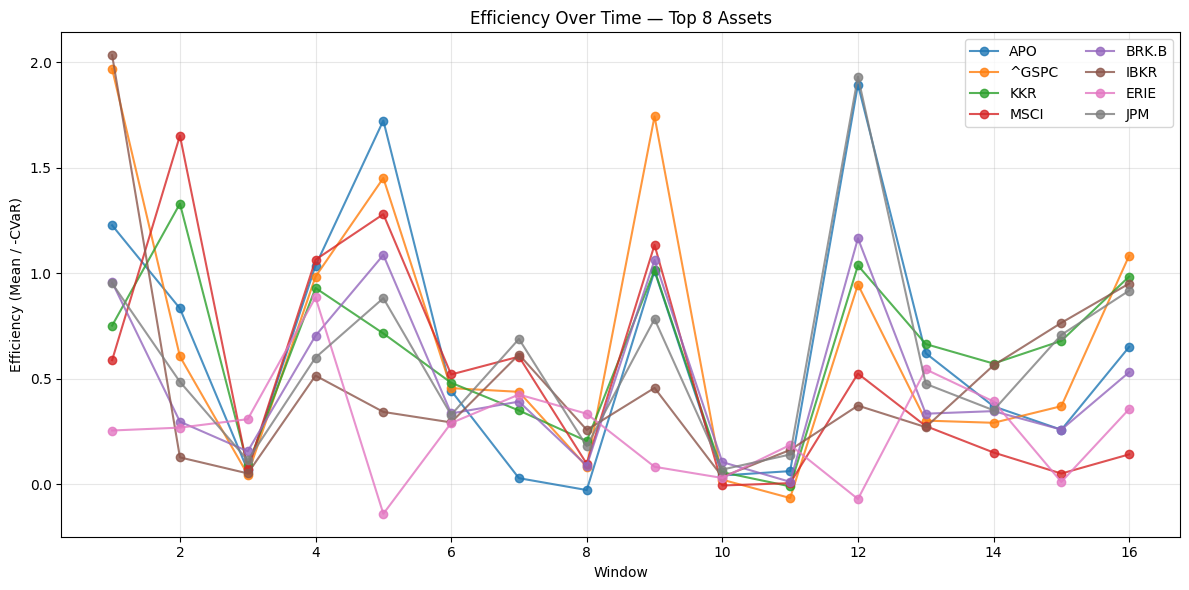

In [20]:
top_assets = final_ranking.head(8).index.tolist()

plt.figure(figsize=(12, 6))
for ticker in top_assets:
    asset_data = all_results[all_results['Ticker'] == ticker]
    plt.plot(asset_data['Window'], asset_data['Efficiency'], marker='o', label=ticker, alpha=0.8)

plt.xlabel('Window')
plt.ylabel('Efficiency (Mean / -CVaR)')
plt.title('Efficiency Over Time — Top 8 Assets')
plt.legend(loc='upper right', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

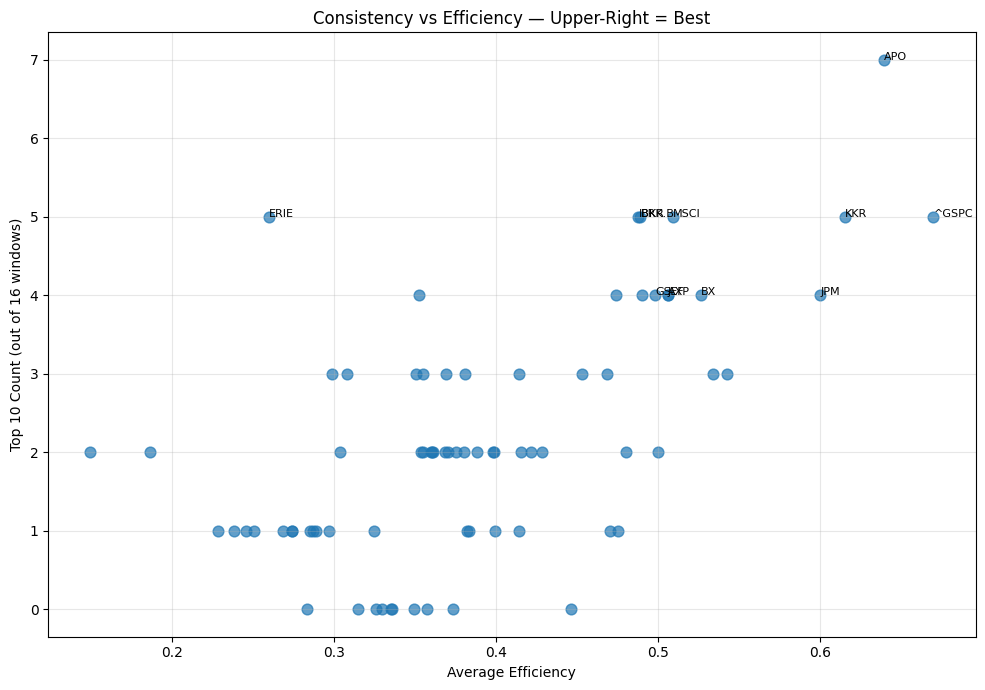

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(final_ranking['Mean_Eff'], final_ranking['Top10_Count'], s=60, alpha=0.7)

for ticker in final_ranking.head(12).index:
    plt.annotate(ticker, 
                 (final_ranking.loc[ticker, 'Mean_Eff'], final_ranking.loc[ticker, 'Top10_Count']),
                 fontsize=8)

plt.xlabel('Average Efficiency')
plt.ylabel('Top 10 Count (out of 16 windows)')
plt.title('Consistency vs Efficiency — Upper-Right = Best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_266/1163963547.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=ordered_tickers)


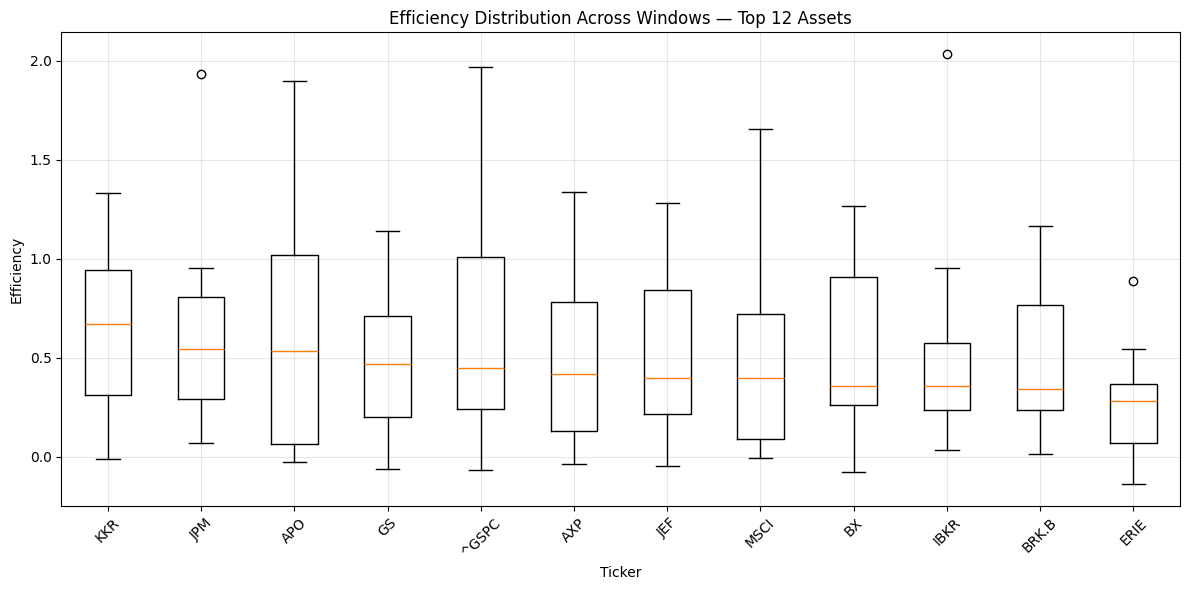

In [22]:
top12 = final_ranking.head(12).index.tolist()
plot_data = all_results[all_results['Ticker'].isin(top12)]

# Order by median efficiency
ordered_tickers = plot_data.groupby('Ticker')['Efficiency'].median().sort_values(ascending=False).index.tolist()

# Prepare data for boxplot
box_data = [plot_data[plot_data['Ticker'] == t]['Efficiency'].values for t in ordered_tickers]

plt.figure(figsize=(12, 6))
plt.boxplot(box_data, labels=ordered_tickers)
plt.xticks(rotation=45)
plt.xlabel('Ticker')
plt.ylabel('Efficiency')
plt.title('Efficiency Distribution Across Windows — Top 12 Assets')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

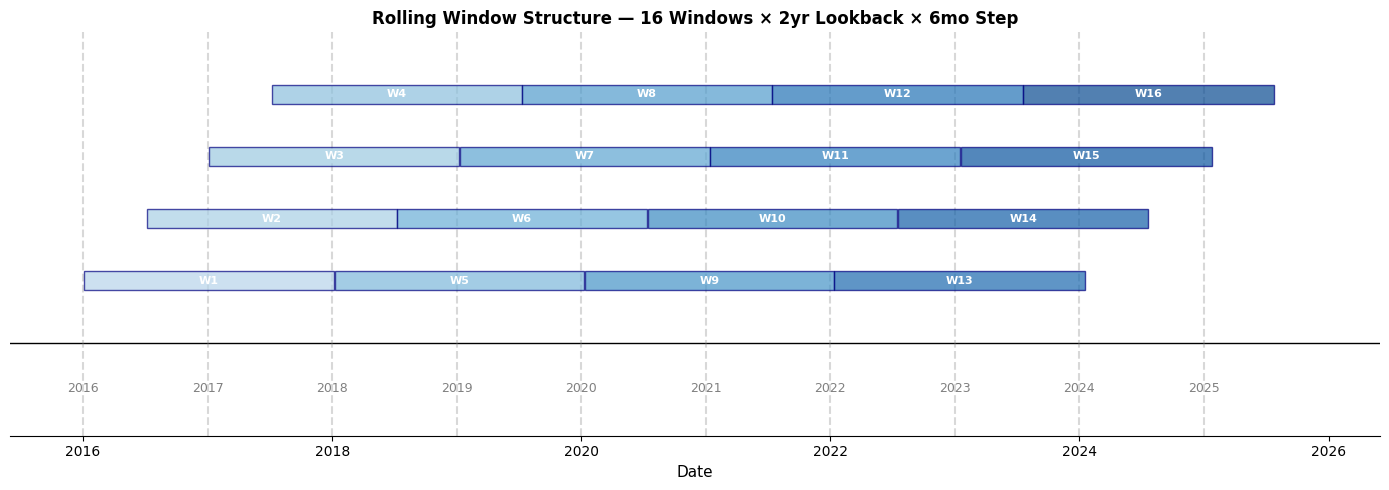

In [23]:
# Cell 17: Visual — Rolling window structure

fig, ax = plt.subplots(figsize=(14, 5))

# Timeline
years = pd.date_range('2016-01-01', '2025-12-31', freq='YS')
ax.axhline(y=0, color='black', linewidth=1, zorder=1)

# Year markers
for year in years:
    ax.axvline(x=year, color='gray', linestyle='--', alpha=0.3, zorder=1)
    ax.text(year, -0.8, str(year.year), ha='center', fontsize=9, color='gray')

# Draw windows
colors = plt.cm.Blues(np.linspace(0.3, 0.9, n_windows))
window_height = 0.3

for w in range(n_windows):
    start_idx = w * step_size
    end_idx = start_idx + window_size
    start_date = pnl.index[start_idx]
    end_date = pnl.index[end_idx - 1]
    
    y_pos = (w % 4) + 1  # stack 4 high to show overlap
    
    rect = plt.Rectangle((start_date, y_pos - window_height/2), 
                          end_date - start_date, window_height,
                          facecolor=colors[w], edgecolor='navy', alpha=0.7, zorder=2)
    ax.add_patch(rect)
    ax.text(start_date + (end_date - start_date)/2, y_pos, f'W{w+1}', 
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

ax.set_xlim(pd.Timestamp('2015-06-01'), pd.Timestamp('2026-06-01'))
ax.set_ylim(-1.5, 5)
ax.set_yticks([])
ax.set_xlabel('Date', fontsize=11)
ax.set_title('Rolling Window Structure — 16 Windows × 2yr Lookback × 6mo Step', fontsize=12, fontweight='bold')
ax.spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()
plt.show()

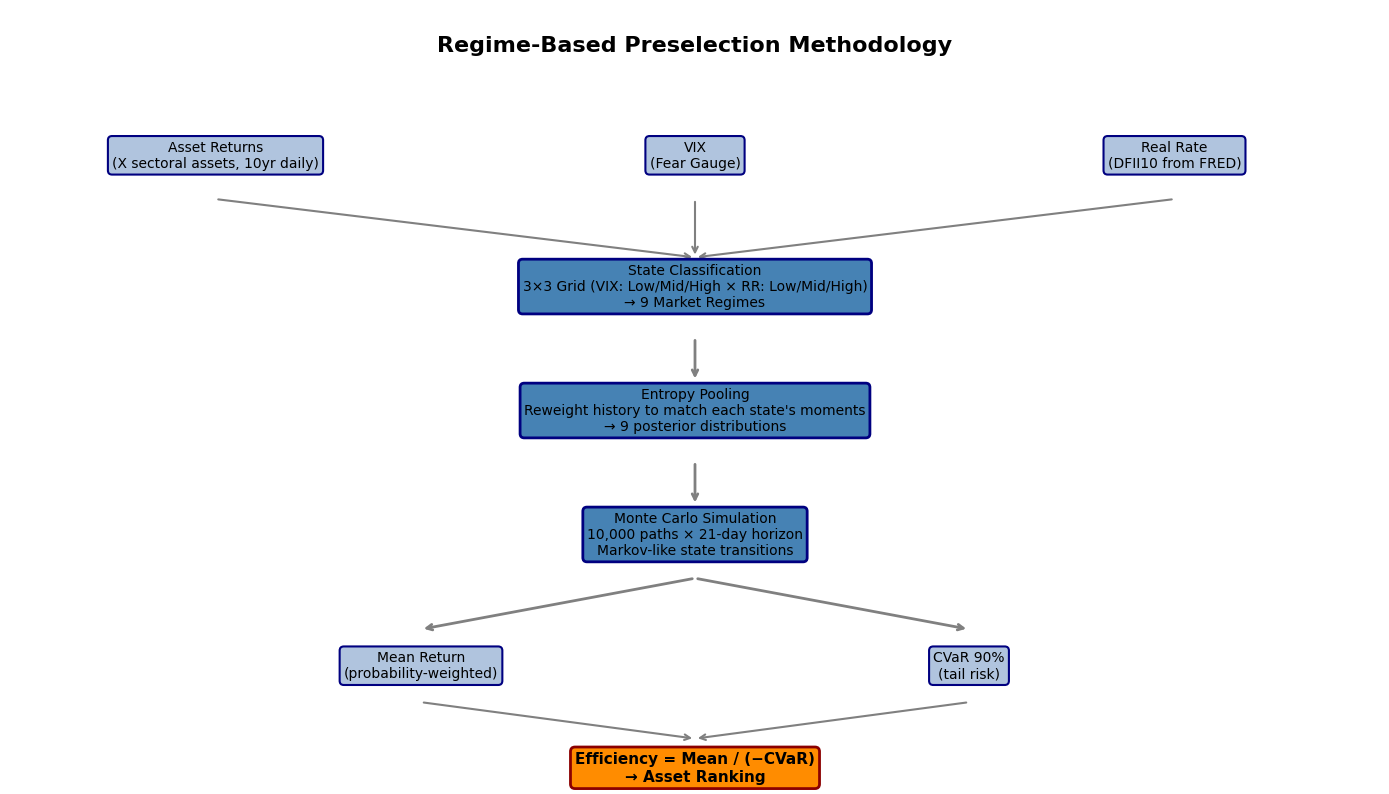

In [24]:
# Cell 18: Visual — Methodology pipeline flowchart

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Box style
box_kwargs = dict(boxstyle='round,pad=0.3', facecolor='steelblue', edgecolor='navy', linewidth=2)
box_kwargs_light = dict(boxstyle='round,pad=0.3', facecolor='lightsteelblue', edgecolor='navy', linewidth=1.5)
box_kwargs_result = dict(boxstyle='round,pad=0.3', facecolor='darkorange', edgecolor='darkred', linewidth=2)

# Title
ax.text(5, 9.5, 'Regime-Based Preselection Methodology', fontsize=16, fontweight='bold', 
        ha='center', va='center')

# Row 1: Inputs
ax.text(1.5, 8, 'Asset Returns\n(X sectoral assets, 10yr daily)', fontsize=10, ha='center', va='center', 
        bbox=box_kwargs_light)
ax.text(5, 8, 'VIX\n(Fear Gauge)', fontsize=10, ha='center', va='center', 
        bbox=box_kwargs_light)
ax.text(8.5, 8, 'Real Rate\n(DFII10 from FRED)', fontsize=10, ha='center', va='center', 
        bbox=box_kwargs_light)

# Arrows down
for x in [1.5, 5, 8.5]:
    ax.annotate('', xy=(5, 6.6), xytext=(x, 7.4), 
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Row 2: State Classification
ax.text(5, 6.2, 'State Classification\n3×3 Grid (VIX: Low/Mid/High × RR: Low/Mid/High)\n→ 9 Market Regimes', 
        fontsize=10, ha='center', va='center', bbox=box_kwargs)

# Arrow down
ax.annotate('', xy=(5, 4.9), xytext=(5, 5.5), arrowprops=dict(arrowstyle='->', color='gray', lw=2))

# Row 3: Entropy Pooling
ax.text(5, 4.5, 'Entropy Pooling\nReweight history to match each state\'s moments\n→ 9 posterior distributions', 
        fontsize=10, ha='center', va='center', bbox=box_kwargs)

# Arrow down
ax.annotate('', xy=(5, 3.2), xytext=(5, 3.8), arrowprops=dict(arrowstyle='->', color='gray', lw=2))

# Row 4: Simulation
ax.text(5, 2.8, 'Monte Carlo Simulation\n10,000 paths × 21-day horizon\nMarkov-like state transitions', 
        fontsize=10, ha='center', va='center', bbox=box_kwargs)

# Arrow down split
ax.annotate('', xy=(3, 1.5), xytext=(5, 2.2), arrowprops=dict(arrowstyle='->', color='gray', lw=2))
ax.annotate('', xy=(7, 1.5), xytext=(5, 2.2), arrowprops=dict(arrowstyle='->', color='gray', lw=2))

# Row 5: Outputs
ax.text(3, 1, 'Mean Return\n(probability-weighted)', fontsize=10, ha='center', va='center', 
        bbox=box_kwargs_light)
ax.text(7, 1, 'CVaR 90%\n(tail risk)', fontsize=10, ha='center', va='center', 
        bbox=box_kwargs_light)

# Arrows to final
ax.annotate('', xy=(5, 0.0), xytext=(3, 0.5), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.annotate('', xy=(5, 0.0), xytext=(7, 0.5), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Final output
ax.text(5, -0.4, 'Efficiency = Mean / (−CVaR)\n→ Asset Ranking', fontsize=11, ha='center', va='center', 
        bbox=box_kwargs_result, fontweight='bold')

plt.tight_layout()
plt.show()

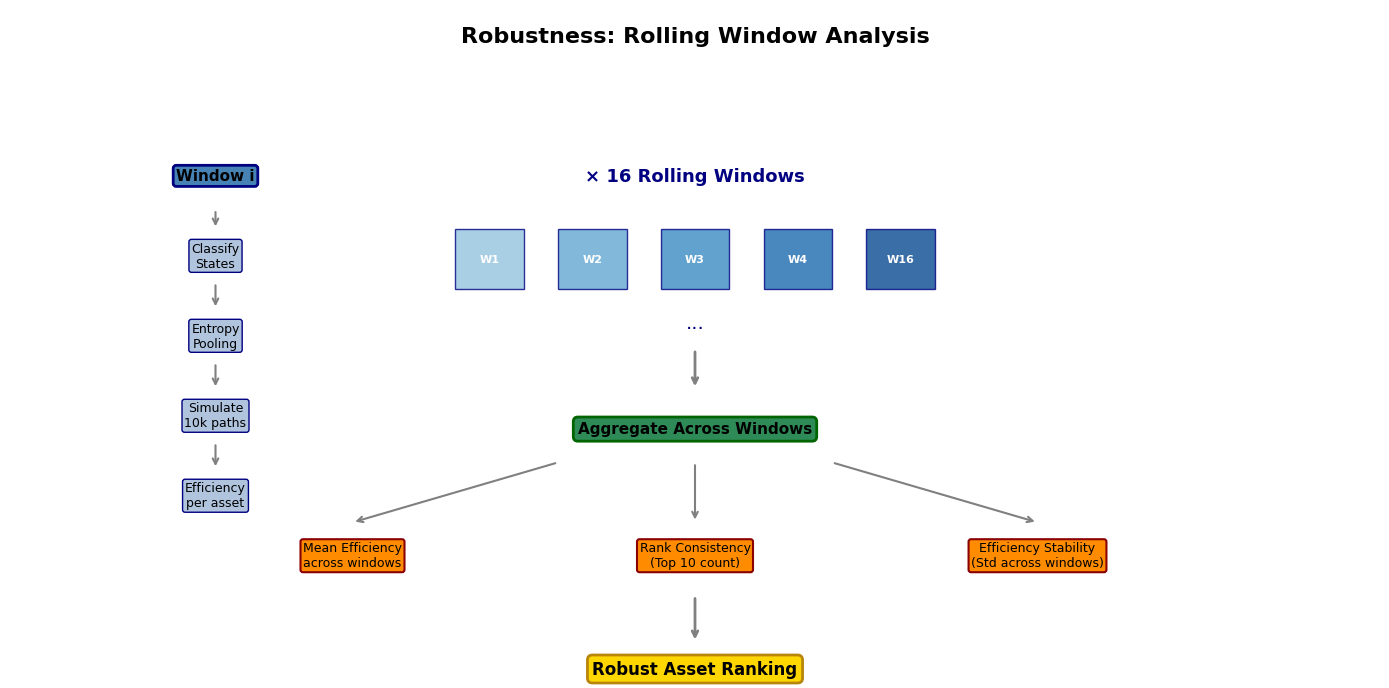

In [25]:
# Cell 19: Visual — Robustness loop across windows

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(5, 9.5, 'Robustness: Rolling Window Analysis', fontsize=16, fontweight='bold', ha='center')

# Left side: Single window pipeline (compact)
box_main = dict(boxstyle='round,pad=0.2', facecolor='steelblue', edgecolor='navy', linewidth=2)
box_light = dict(boxstyle='round,pad=0.2', facecolor='lightsteelblue', edgecolor='navy', linewidth=1)

ax.text(1.5, 7.5, 'Window i', fontsize=11, ha='center', va='center', bbox=box_main, fontweight='bold')
ax.text(1.5, 6.3, 'Classify\nStates', fontsize=9, ha='center', va='center', bbox=box_light)
ax.text(1.5, 5.1, 'Entropy\nPooling', fontsize=9, ha='center', va='center', bbox=box_light)
ax.text(1.5, 3.9, 'Simulate\n10k paths', fontsize=9, ha='center', va='center', bbox=box_light)
ax.text(1.5, 2.7, 'Efficiency\nper asset', fontsize=9, ha='center', va='center', bbox=box_light)

# Arrows in pipeline
for y1, y2 in [(7.0, 6.7), (5.9, 5.5), (4.7, 4.3), (3.5, 3.1)]:
    ax.annotate('', xy=(1.5, y2), xytext=(1.5, y1), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Loop visual — multiple windows
ax.text(5, 7.5, '× 16 Rolling Windows', fontsize=13, ha='center', va='center', fontweight='bold', color='navy')

# Window icons
window_colors = plt.cm.Blues(np.linspace(0.4, 0.9, 5))
for i, x in enumerate([3.5, 4.25, 5, 5.75, 6.5]):
    rect = plt.Rectangle((x-0.25, 5.8), 0.5, 0.9, facecolor=window_colors[i], edgecolor='navy', alpha=0.8)
    ax.add_patch(rect)
    ax.text(x, 6.25, f'W{i+1 if i < 4 else 16}', fontsize=8, ha='center', va='center', color='white', fontweight='bold')

ax.text(5, 5.3, '...', fontsize=14, ha='center', va='center', color='navy')

# Arrow to aggregation
ax.annotate('', xy=(5, 4.3), xytext=(5, 4.9), arrowprops=dict(arrowstyle='->', color='gray', lw=2))

# Aggregation box
box_agg = dict(boxstyle='round,pad=0.3', facecolor='seagreen', edgecolor='darkgreen', linewidth=2)
ax.text(5, 3.7, 'Aggregate Across Windows', fontsize=11, ha='center', va='center', bbox=box_agg, fontweight='bold')

# Three outputs
box_out = dict(boxstyle='round,pad=0.2', facecolor='darkorange', edgecolor='darkred', linewidth=1.5)

ax.annotate('', xy=(2.5, 2.3), xytext=(4, 3.2), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.annotate('', xy=(5, 2.3), xytext=(5, 3.2), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.annotate('', xy=(7.5, 2.3), xytext=(6, 3.2), arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax.text(2.5, 1.8, 'Mean Efficiency\nacross windows', fontsize=9, ha='center', va='center', bbox=box_out)
ax.text(5, 1.8, 'Rank Consistency\n(Top 10 count)', fontsize=9, ha='center', va='center', bbox=box_out)
ax.text(7.5, 1.8, 'Efficiency Stability\n(Std across windows)', fontsize=9, ha='center', va='center', bbox=box_out)

# Final arrow
ax.annotate('', xy=(5, 0.5), xytext=(5, 1.2), arrowprops=dict(arrowstyle='->', color='gray', lw=2))

# Final result
box_final = dict(boxstyle='round,pad=0.3', facecolor='gold', edgecolor='darkgoldenrod', linewidth=2)
ax.text(5, 0.1, 'Robust Asset Ranking', fontsize=12, ha='center', va='center', bbox=box_final, fontweight='bold')

plt.tight_layout()
plt.show()